In [1]:
from __future__ import print_function

import sys
sys.path.append('../src/')

from almaDatabaseQuery import *

import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

### New function to make a list and to select calibrator

I add a function to retrieve all the flux from the ALMA Calibrator list with its frequency and observing date, and to retrieve redshift (z) from NED.

In [2]:
file_listcal = "alma_sourcecat_searchresults_20180419.csv"

In [3]:
q = databaseQuery()

#### Example, retrieve all the calibrator with a flux > 0.1 Jy:

In [4]:
listcal = q.read_calibratorlist(file_listcal, fluxrange=[0.1, 999999])

In [5]:
len(listcal)

1673

In [6]:
print("Name: ", listcal[0][0])
print("J2000 RA, dec: ", listcal[0][1], listcal[0][2])
print("Alias: ", listcal[0][3])
print("Flux density: ", listcal[0][4])
print("Band: ", listcal[0][5])
print("Freq: ", listcal[0][6])
print("Obs date: ", listcal[0][4])

Name:  J2253+1608
J2000 RA, dec:  343.490616417 16.1482113611
Alias:  ['J2253+1608', 'J2253+161', 'J225358+160853', '3C454.3', 'B2251+158']
Flux density:  [5.72, 13.78, 14.47, 8.73, 3.579]
Band:  ['7', '3', '3', '6', '9']
Freq:  [337460000000.0, 103490000000.0, 91460000000.0, 233000000000.0, 673000000000.0]
Obs date:  [5.72, 13.78, 14.47, 8.73, 3.579]


#### Select all calibrators that heve been observed at least in 3 Bands [ >60s in B3, B6, B7]

- already queried and convert it to SQL
- exclude Cycle 0, array 12m

In [7]:
report, resume = q.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db", \
                                    maxFreqRes=999999999, array='12m', \
                                    excludeCycle0=True, \
                                    selectPol=False, \
                                    minTimeBand={3:60., 6:60., 7:60.}, \
                                    silent=True)

Number of accepted source:  186


We can write a "report file" or only use the "resume data", some will have redshift data retrieved from NED.

In [8]:
print("Name: ", resume[0][0])
print("From NED: ")
print("Name: ", resume[0][3])
print("J2000 RA, dec: ", resume[0][4], resume[0][5])
print("z: ", resume[0][6])
print("Total # of projects: ", resume[0][7])
print("Total # of UIDs: ", resume[0][8])
print("Gal lon: ", resume[0][9])
print("Gal lat: ", resume[0][10])

Name:  J2253+1608
From NED: 
Name:  3C 454.3
J2000 RA, dec:  343.49062 16.14821
z:  0.859
Total # of projects:  30
Total # of UIDs:  56
Gal lon:  86.111103912
Gal lat:  -38.1837784919


Sometimes there is no redshift information found in NED

#### Combining listcal and resume information.

In [9]:
for i, obj in enumerate(resume):
    for j, cal in enumerate(listcal):
        if obj[0] == cal[0]: # same name
            obj.append(cal[4:]) # add [flux, band, flux obsdate] in the "resume"

### Select objects which has redshift
- collect the flux, band, freq, and obsdate
- plot based on the Band

In [10]:
def collect_z_and_flux(Band):
    z = []
    flux = []
    for idata in resume:
        if idata[6] is not None: # select object which has redshift information
            fluxnya = idata[11][0]
            bandnya = idata[11][1]
            freqnya = idata[11][2]
            datenya  = idata[11][3]
            for i, band in enumerate(bandnya):
                if band == str(Band): # take only first data
                    flux.append(fluxnya[i])
                    z.append(idata[6])
                    break
                    
    return z, flux

In [11]:
z3, f3 = collect_z_and_flux(3)
print("Number of seleted source in B3: ", len(z3))
z6, f6 = collect_z_and_flux(6)
print("Number of seleted source in B6: ", len(z6))
z7, f7 = collect_z_and_flux(7)
print("Number of seleted source in B7: ", len(z7))

Number of seleted source in B3:  146
Number of seleted source in B6:  113
Number of seleted source in B7:  122


### Plot Flux vs Redshift

- same object will located in the same z
- some of them will not have flux in all 3 bands.

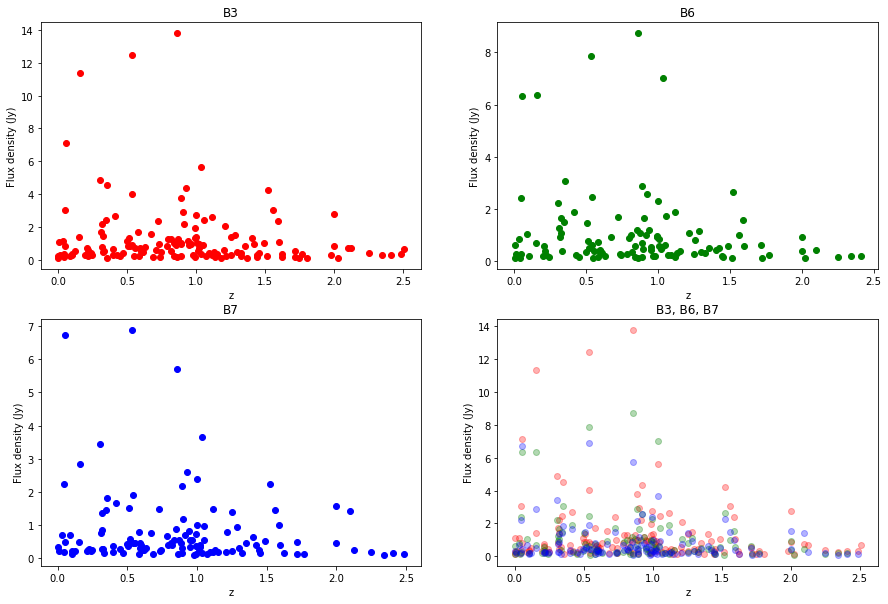

In [12]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(z3, f3, 'ro')
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B3")

plt.subplot(222)
plt.plot(z6, f6, 'go')
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B6")

plt.subplot(223)
plt.plot(z7, f7, 'bo')
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B7")

plt.subplot(224)
plt.plot(z3, f3, 'ro', z6, f6, 'go', z7, f7, 'bo', alpha=0.3)
plt.xlabel("z")
plt.ylabel("Flux density (Jy)")
plt.title("B3, B6, B7")

### Plot log(Luminosity) vs redshift

In [13]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

How to calculate luminosity:

$$L_{\nu} (\nu_{e}) = \frac{4 \pi D_{L}^2}{1+z} \cdot S_{\nu} (\nu_{o})$$

Notes: 
- Calculate Luminosity or Power in a specific wavelength (without k-correction e.g. using spectral index)
- $L_{\nu}$ in watt/Hz, in emited freq
- $S_{\nu}$ in watt/m$^2$/Hz, in observed freq
- $D_L$ is luminosity distance, calculated using `astropy.cosmology` function
- need to calculate distance in meter
- need to convert Jy to watt/m$^2$/Hz ----- $\times 10^{-26}$

In [14]:
def calc_power(z, flux):
    """
    z = redshift
    flux in Jy
    """
    z = np.array(z)
    flux = np.array(flux)
    
    dL = cosmo.luminosity_distance(z).to(u.meter).value # Luminosity distance
    luminosity = 4.0*np.pi*dL*dL/(1.0+z) * flux * 1e-26
    
    return z, luminosity

#### Plot $\log_{10}(L)$ vs $z$

In [15]:
z3, l3 = calc_power(z3, f3)
z6, l6 = calc_power(z6, f6)
z7, l7 = calc_power(z7, f7)

zdummy = np.linspace(0.001, 2.5, 100)
fdummy = 0.1 # Jy, our cut threshold
zdummy, Ldummy0 = calc_power(zdummy, fdummy)
zdummy, Ldummy3 = calc_power(zdummy, np.max(f3))
zdummy, Ldummy6 = calc_power(zdummy, np.max(f6))
zdummy, Ldummy7 = calc_power(zdummy, np.max(f7))

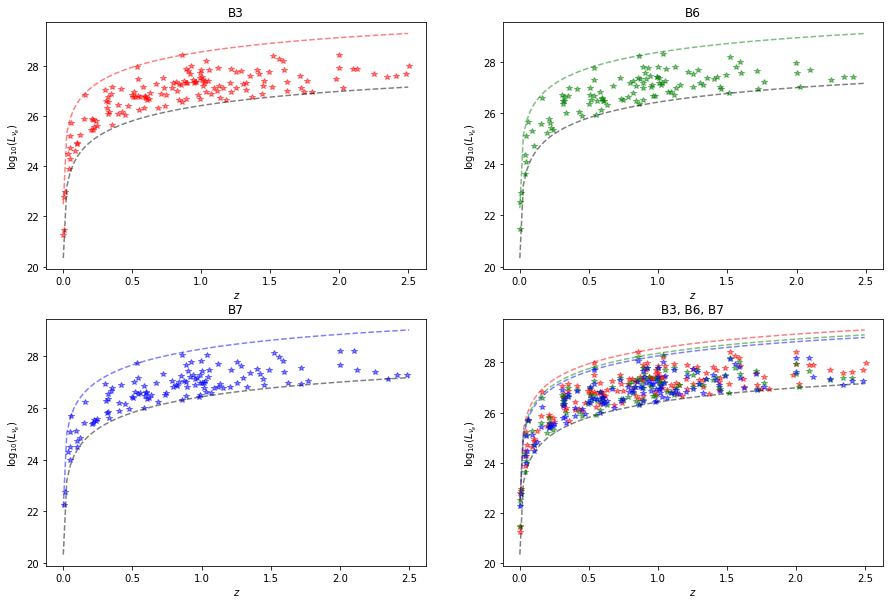

In [16]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(z3, np.log10(l3), 'r*', \
         zdummy, np.log10(Ldummy0), 'k--', zdummy, np.log10(Ldummy3), 'r--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B3")

plt.subplot(222)
plt.plot(z6, np.log10(l6), 'g*', \
         zdummy, np.log10(Ldummy0), 'k--', zdummy, np.log10(Ldummy6), 'g--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B6")

plt.subplot(223)
plt.plot(z7, np.log10(l7), 'b*', \
         zdummy, np.log10(Ldummy0), 'k--', zdummy, np.log10(Ldummy7), 'b--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B7")

plt.subplot(224)
plt.plot(z3, np.log10(l3), 'r*', z6, np.log10(l6), 'g*', z7, np.log10(l7), 'b*', \
         zdummy, np.log10(Ldummy0), 'k--', \
         zdummy, np.log10(Ldummy3), 'r--', \
         zdummy, np.log10(Ldummy6), 'g--', \
         zdummy, np.log10(Ldummy7), 'b--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B3, B6, B7")

Black-dashed line are for 0.1 Jy flux.

### Without log10

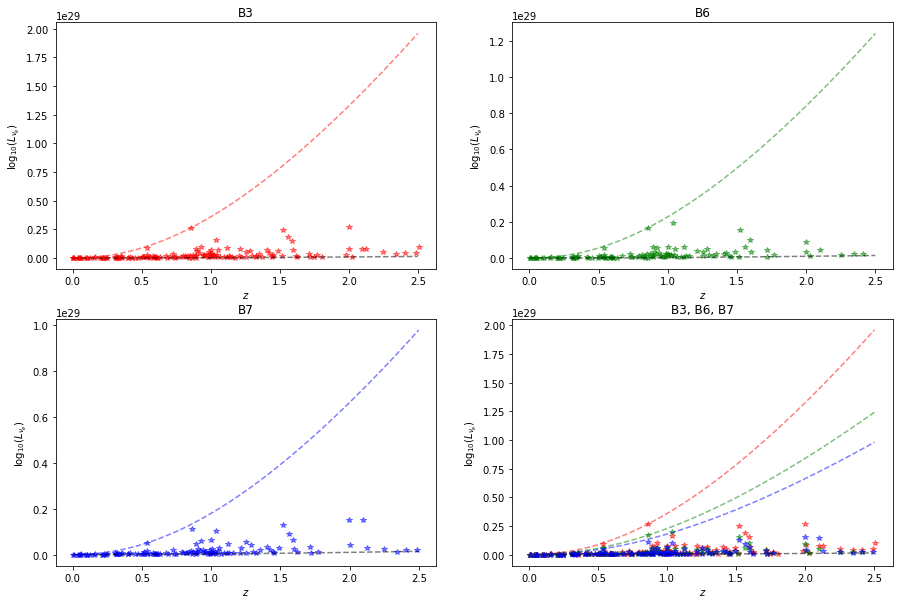

In [17]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(z3, l3, 'r*', zdummy, Ldummy0, 'k--', zdummy, Ldummy3, 'r--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B3")

plt.subplot(222)
plt.plot(z6, l6, 'g*', zdummy, Ldummy0, 'k--', zdummy, Ldummy6, 'g--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B6")

plt.subplot(223)
plt.plot(z7, l7, 'b*', zdummy, Ldummy0, 'k--', zdummy, Ldummy7, 'b--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B7")

plt.subplot(224)
plt.plot(z3, l3, 'r*', z6, l6, 'g*', z7, l7, 'b*', \
         zdummy, Ldummy0, 'k--', zdummy, Ldummy3, 'r--', \
         zdummy, Ldummy6, 'g--', zdummy, Ldummy7, 'b--', alpha=0.5)
plt.xlabel(r"$z$"); plt.ylabel(r"$\log_{10}(L_{\nu_e})$"); plt.title("B3, B6, B7")